# Surface normals

Author(s): Jukka Aho

**Abstract**: Testing different strategies to calculate surface normals. These are important when calculating mortar projections.

In [1]:
using JuliaFEM

In [2]:
using PyPlot

In [3]:
phi = linspace(pi, 0, 4)
nelements = length(phi)-1
nnodes = length(phi)
elements = []
R = 10.0
for i=1:nelements
    con = [i, mod(i, nnodes)+1]
    seg = JuliaFEM.PSeg(con)
    # create vector field :geometry for elements
    pnts = Vector[]
    for deg in phi[con]
        X = R*[cos(deg), sin(deg)]
        push!(pnts, X)
    end
    JuliaFEM.set_field(seg, :geometry, pnts)
    push!(elements, seg)
end
elements

3-element Array{Any,1}:
 JuliaFEM.PSeg([1,2],Dict{Any,Any}(:geometry=>Array{T,1}[[-10.0,1.2246467991473533e-15],[-4.999999999999998,8.660254037844387]]),1)       
 JuliaFEM.PSeg([2,3],Dict{Any,Any}(:geometry=>Array{T,1}[[-4.999999999999998,8.660254037844387],[5.000000000000001,8.660254037844386]]),1)
 JuliaFEM.PSeg([3,4],Dict{Any,Any}(:geometry=>Array{T,1}[[5.000000000000001,8.660254037844386],[10.0,0.0]]),1)                            

In [4]:
# calculate "local" normals in elements, in a way that
# n = Nᵢnᵢ gives some reasonable results for ξ ∈ [-1, 1]

for el in elements
    nfld = Vector[]
    for xi in Vector[[-1.0], [1.0]]
        t = JuliaFEM.dinterpolate(el, :geometry, xi)
        n = [0 -1; 1 0]*t
        n /= norm(n)
        push!(nfld, n)
    end
    JuliaFEM.set_field(el, :normals, nfld)
end
elements

3-element Array{Any,1}:
 JuliaFEM.PSeg([1,2],Dict{Any,Any}(:geometry=>Array{T,1}[[-10.0,1.2246467991473533e-15],[-4.999999999999998,8.660254037844387]],:normals=>Array{T,1}[[-0.8660254037844386,0.5000000000000002],[-0.8660254037844386,0.5000000000000002]]),1)
 JuliaFEM.PSeg([2,3],Dict{Any,Any}(:geometry=>Array{T,1}[[-4.999999999999998,8.660254037844387],[5.000000000000001,8.660254037844386]],:normals=>Array{T,1}[[1.7763568394002506e-16,1.0],[1.7763568394002506e-16,1.0]]),1)                 
 JuliaFEM.PSeg([3,4],Dict{Any,Any}(:geometry=>Array{T,1}[[5.000000000000001,8.660254037844386],[10.0,0.0]],:normals=>Array{T,1}[[0.8660254037844387,0.5],[0.8660254037844387,0.5]]),1)                                                     

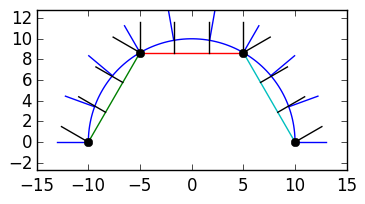

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f54db468110>

In [5]:
function plot_stuff(elements)
    phi2 = linspace(0, pi, 100)
    phi3 = linspace(0, pi, 10)
    phi4 = linspace(0, pi, 4)
    figure(figsize=(4, 2))
    plot(R*cos(phi2), R*sin(phi2))
    for fi in phi3
        p0 = R*[cos(fi), sin(fi)]
        p1 = (R+3)*[cos(fi), sin(fi)]
        plot([p0[1], p1[1]], [p0[2], p1[2]], "-b")
    end
    axis("equal")
    xlim(-1.5*R, 1.5*R)
    ylim(-0.5*R, 1.5*R)

    # create a array of vectors
    xis = Vector[[xi] for xi in linspace(-1, 1)]
    for el in elements
        coords = JuliaFEM.interpolate(el, :geometry, xis)
        # extract 1 and 2 components from array of coordinates
        xs = [X[1] for X in coords]
        ys = [X[2] for X in coords]
        plot(xs, ys, "-")
    end

    xis = Vector[[xi] for xi in linspace(-1, 1, 4)]
    for el in elements
        coords = JuliaFEM.interpolate(el, :geometry, xis)
        normals = JuliaFEM.interpolate(el, :normals, xis)
        for i=1:length(normals)
            p0 = coords[i]
            p1 = coords[i] + normals[i]/norm(normals[i])*3
            plot([p0[1], p1[1]], [p0[2], p1[2]], "-k")
        end
    end
    plot(R*cos(phi4), R*sin(phi4), "ko")
end

plot_stuff(elements)

Blue lines "accurate" normal direction, other lines are approximations.

**Strategy 1**: average normals of adjacent elements in common nodes, maybe by weighting it with areas / lenghts ...

In [6]:
using JuliaFEM: get_connectivity, get_field, set_field

In [7]:
"""
Alter normal field such that normals of adjacent elements are averaged.
"""
function average_normals(elements, normal_field=:normals)
    d = Dict()
    for el in elements
        c = get_connectivity(el)
        n = get_field(el, normal_field)
        for (ci, ni) in zip(c, n)
            d[ci] = haskey(d, ci) ? d[ci] + ni : ni
        end
    end
    for (ci, ni) in d
        d[ci] /= norm(d[ci])
    end
    for el in elements
        c = get_connectivity(el)
        new_normals = [d[ci] for ci in c]
        set_field(el, normal_field, new_normals)
    end
end
average_normals(elements)

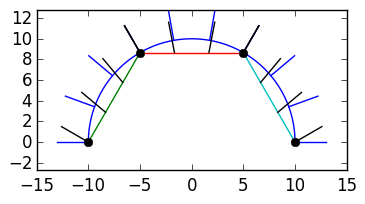

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f54db2c27d0>

In [8]:
plot_stuff(elements)

**Strategy 2**: Fit field. Here we define normal function and fit field for that.

In [9]:
using JuliaFEM: Element, get_number_of_basis_functions, get_detJ, get_basis

"""
Fit field s.t. || ∫ (Nᵢ(ξ)αᵢ - f(el, ξ)) dS || -> min!
"""
function fit_field!(el::Element, field, f, fixed_coeffs=Int[])
    w = [
        128/225,
        (332+13*sqrt(70))/900,
        (332+13*sqrt(70))/900,
        (332-13*sqrt(70))/900,
        (332-13*sqrt(70))/900]
    xi = Vector[
        [0.0],
        [ 1/3*sqrt(5 - 2*sqrt(10/7))],
        [-1/3*sqrt(5 - 2*sqrt(10/7))], 
        [ 1/3*sqrt(5 + 2*sqrt(10/7))],
        [-1/3*sqrt(5 + 2*sqrt(10/7))]]
    n = get_number_of_basis_functions(el)
    fld = get_field(el, field)
    nfld = length(fld[1])
    #Logging.debug("dim of field $field: $nfld")

    M = zeros(n, n)
    b = zeros(n, nfld)
    for i=1:length(w)
        detJ = get_detJ(el, xi[i])
        N = get_basis(el, xi[i])
        M += w[i]*N*N'*detJ
        fi = f(el, xi[i])
        for j=1:nfld
            b[:, j] += w[i]*N*fi[j]*detJ
        end
    end

    coeffs = zeros(n)
    for j=1:nfld
        for k=1:n
            coeffs[k] = fld[k][j]
        end
        if length(fixed_coeffs) != 0
            # constrained problem, some coefficients are fixed
            N = Int[] # rest of coeffs
            S = Int[] # fixed coeffs
            for i = 1:n
                if i in fixed_coeffs
                    push!(S, i)
                else
                    push!(N, i)
                end
            end
            lhs = M[N,N]
            rhs = b[N,j] - M[N,S]*coeffs[S]
            coeffs[N] = lhs \ rhs
        else
            coeffs[:] = M \ b[:,j]
        end
        for k=1:n
            fld[k][j] = coeffs[k]
        end
    end
    set_field(el, field, fld)
    return
end

fit_field! (generic function with 2 methods)

In [10]:
using JuliaFEM: interpolate
using ForwardDiff

"""
Return accurate normal for element based on a geometry.
"""
function f(el, xi)
    geom_info(X) = X[1]^2 + X[2]^2 - 10^2
    X = interpolate(el, :geometry, xi)
    n = ForwardDiff.gradient(geom_info, X)
    n / norm(n)
end

#fit_field(elements[1], :normals, f)
f(elements[1], [0.0])

2-element Array{Float64,1}:
 -0.866025
  0.5     

In [11]:
for el in elements
    fit_field!(el, :normals, f)
end

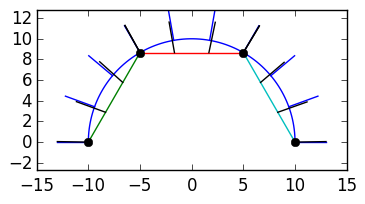

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f54db2e7910>

In [12]:
plot_stuff(elements)

Normal direction fitted in least squares sense. Why not also fit geometry based on normal direction information?

In [13]:
using JuliaFEM: set_degree, get_number_of_basis_functions, dinterpolate
for el in elements
    set_degree(el, 2)
    for field in (:geometry, :normals)
        push!(el.fields[field], [0.0, 0.0])
        el.fields[field] = el.fields[field][1:get_number_of_basis_functions(el)]
    end
end

In [14]:
using JuliaFEM: get_dbasisdxi

"""
Fit field s.t. || ∫ d/dξ(∑ᵢNᵢ(ξ)αᵢ - f(el, ξ)) dS || -> min!
"""
function fit_derivative_field!(el::Element, field, f, fixed_coeffs=Int[])
    w = [
        128/225,
        (332+13*sqrt(70))/900,
        (332+13*sqrt(70))/900,
        (332-13*sqrt(70))/900,
        (332-13*sqrt(70))/900]
    xi = Vector[
        [0.0],
        [ 1/3*sqrt(5 - 2*sqrt(10/7))],
        [-1/3*sqrt(5 - 2*sqrt(10/7))], 
        [ 1/3*sqrt(5 + 2*sqrt(10/7))],
        [-1/3*sqrt(5 + 2*sqrt(10/7))]]
    n = get_number_of_basis_functions(el)
    fld = get_field(el, field)
    nfld = length(fld[1])
    #Logging.debug("dim of field $field: $nfld")

    M = zeros(n, n)
    b = zeros(n, nfld)
    for i=1:length(w)
        detJ = get_detJ(el, xi[i])
        dN = get_dbasisdxi(el, xi[i])
        N = get_basis(el, xi[i])
        M += w[i]*dN*dN'*detJ
        fi = f(el, xi[i])
        for j=1:nfld
            b[:, j] += w[i]*dN*fi[j]*detJ
        end
    end

    coeffs = zeros(n)
    for j=1:nfld
        for k=1:n
            coeffs[k] = fld[k][j]
        end
        if length(fixed_coeffs) != 0
            println("constrained problem, some coefficients are fixed")
            N = Int[] # rest of coeffs
            S = Int[] # fixed coeffs
            for i = 1:n
                if i in fixed_coeffs
                    push!(S, i)
                else
                    push!(N, i)
                end
            end
            lhs = M[N,N]
            rhs = b[N,j] - M[N,S]*coeffs[S]
            coeffs[N] = lhs \ rhs
        else
            coeffs[:] = M \ b[:,j]
        end
        for k=1:n
            fld[k][j] = coeffs[k]
        end
    end
    set_field(el, field, fld)
    return
end

fit_derivative_field! (generic function with 2 methods)

In [15]:
"""
Return tangent vector of elmeent in point ξ.
"""
function tangent(el, xi)
    normal = JuliaFEM.interpolate(el, :normals, xi)
    [0 -1; 1 0]'*normal*5
end

fit_derivative_field!(elements[1], :geometry, tangent, Int[1, 2])

constrained problem, some coefficients are fixed
constrained problem, some coefficients are fixed


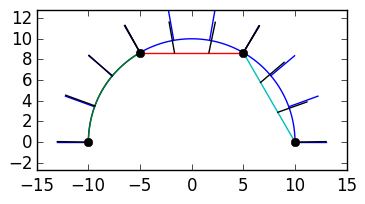

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f54db3cf210>

In [16]:
plot_stuff(elements)